# **Contexte général**

Dans le cadre du cours sur les **Modèles Linéaires Généralisés**, 
vous êtes amené(e) à appliquer les concepts théoriques développés 

(régression logistique, validation des modèles,
diagnostics de résidus, analyse de la multicolinéarité, choix de modèles) 

sur des données réelles issues de la plateforme Kaggle.

Ce projet vise à **évaluer votre capacité** à :

- Formaliser un probléme en termes de GLM adapté,

- Maîtriser les techniques d’estimation par maximum de vraisemblance,

- Réaliser un diagnostic rigoureux de la qualité d’ajustement du modèle,

- Détecter les anomalies, multicolinéarités et problèmes de surdispersion éventuels,

- Proposer une analyse critique et justifiée des résultats.


## **1. Préparation des données**

### **Importation des Bibliothèques**

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import statsmodels .api as sm
import matplotlib.pyplot as plt 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix,roc_auc_score, roc_curve, f1_score)

### **Chargement du dataset** 

In [2]:
base = pd.read_csv("heart_cleveland_upload.csv")
base.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


### **Nettoyage des données**

In [3]:
# Copie de la base
data = base.copy()

In [4]:
data.shape

(297, 14)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB


In [6]:
data.isnull().sum()

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64

Notre base de données est composée de **297 observations** et **14 variables** dont **cinq (5) quantitatives** et 

**neuf (9) qualitatives** et ne présente pas de données manquantes.

In [7]:
data.duplicated().sum()

0

## **Analyse Exploratoire des Données (EDA)**

### **Sélection de la liste de variables utiles à l'analyse**

In [8]:
data.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'condition'],
      dtype='object')

In [9]:
# Selection des variables Numériques
Num_Cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']

In [10]:
# Conversion des variables Quantitatives
quant_vars = ['age', 'trestbps', 'chol', 'thalach']
for col in quant_vars:
  data[col] = pd.to_numeric(data[col], errors='coerce').astype('Int64')

In [11]:
# Selection des variables Qualitatives
Cat_Cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal','condition']

# Conversion des variables Qualitatives
for col in Cat_Cols:
   data[col] = data[col].astype('category')

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   age        297 non-null    Int64   
 1   sex        297 non-null    category
 2   cp         297 non-null    category
 3   trestbps   297 non-null    Int64   
 4   chol       297 non-null    Int64   
 5   fbs        297 non-null    category
 6   restecg    297 non-null    category
 7   thalach    297 non-null    Int64   
 8   exang      297 non-null    category
 9   oldpeak    297 non-null    float64 
 10  slope      297 non-null    category
 11  ca         297 non-null    category
 12  thal       297 non-null    category
 13  condition  297 non-null    category
dtypes: Int64(4), category(9), float64(1)
memory usage: 16.8 KB


### **Recodage des variables catégorielles**

In [13]:
data['sex'] = data['sex'].map({0: 'Femme', 1: 'Homme'})
data['cp'] = data['cp'].map({0: "Angine stable", 1: "Angine instable",2: " Autres douleurs", 3:"Asymptomatique"})
data['fbs'] = data['fbs'].map({0: "Non", 1: "Oui"})
data['restecg'] = data['restecg'].map({0: "Normal", 1: "Anomalies", 2: "Hypertrophie"})
data['exang'] = data['exang'].map({0: "Non", 1: "Oui"})
data['slope'] = data['slope'].map({0: "En hausse", 1: "Stable", 2: "En baisse "})
data['ca'] = data['ca'].map({0: "Absence d'anomalie",1: "Faible",2: "Moyen",3: "Élevé"})
data['thal'] = data['thal'].map({0: "Normal ",1: "Fixe",2: "Réversible"})
data['condition'] = data['condition'].map({0: "Non", 1: "Oui"})

In [14]:
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,Homme,Angine stable,160,234,Oui,Hypertrophie,131,Non,0.1,Stable,Faible,Normal,Non
1,69,Femme,Angine stable,140,239,Non,Normal,151,Non,1.8,En hausse,Moyen,Normal,Non
2,66,Femme,Angine stable,150,226,Non,Normal,114,Non,2.6,En baisse,Absence d'anomalie,Normal,Non
3,65,Homme,Angine stable,138,282,Oui,Hypertrophie,174,Non,1.4,Stable,Faible,Normal,Oui
4,64,Homme,Angine stable,110,211,Non,Hypertrophie,144,Oui,1.8,Stable,Absence d'anomalie,Normal,Non


In [ ]:
data.to_csv("base_recodees.csv")

### **Analyse univariée**

#### **Variables quantitatives**

In [16]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,297.0,54.542088,9.049736,29.0,48.0,56.0,61.0,77.0
trestbps,297.0,131.693603,17.762806,94.0,120.0,130.0,140.0,200.0
chol,297.0,247.350168,51.997583,126.0,211.0,243.0,276.0,564.0
thalach,297.0,149.599327,22.941562,71.0,133.0,153.0,166.0,202.0
oldpeak,297.0,1.055556,1.166123,0.0,0.0,0.8,1.6,6.2


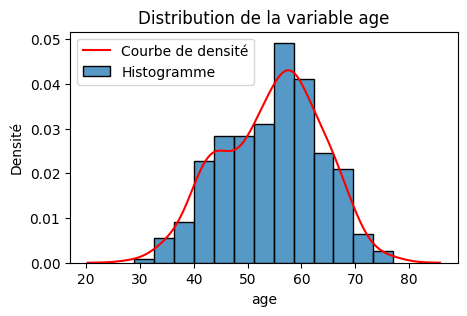

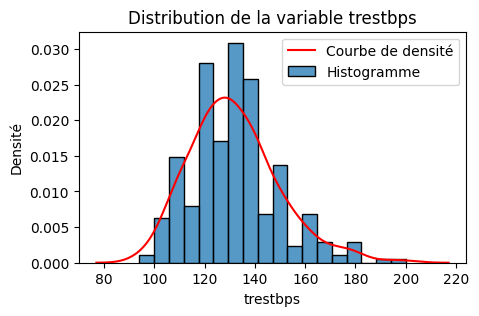

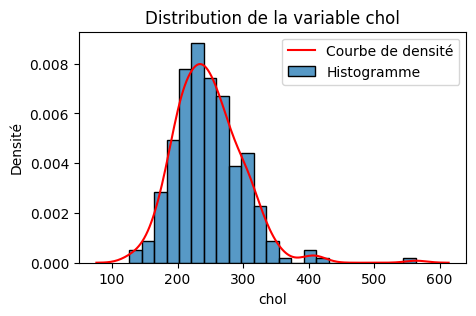

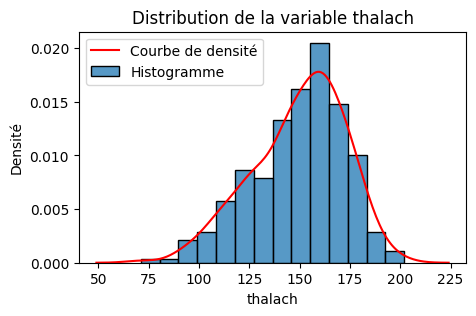

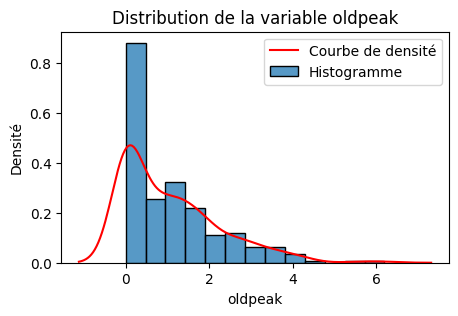

In [17]:
#distribution de chaque variable
for var in Num_Cols : 
    plt.figure(figsize = ( 5 , 3))
    sns.histplot(data = data , x = var , stat = "density" , label = "Histogramme")
    sns.kdeplot(data = data , x = var , label = "Courbe de densité", color = "red")
    plt.xlabel(var)
    plt.ylabel("Densité")
    plt.title(f"Distribution de la variable {var}")
    plt.legend()
    plt.show()

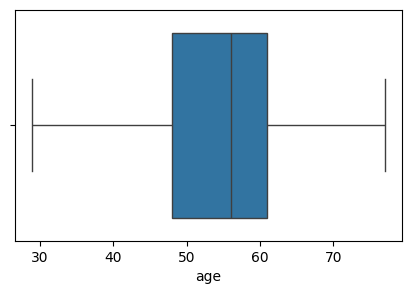

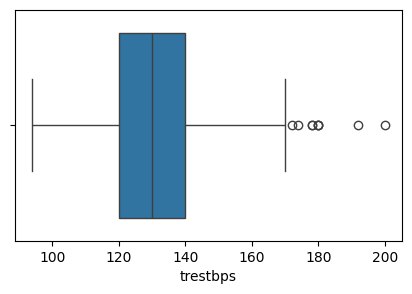

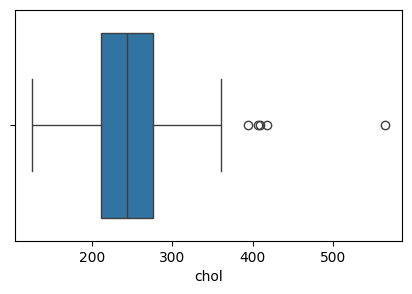

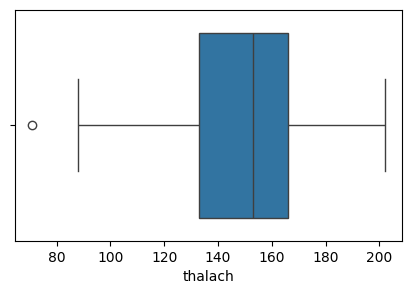

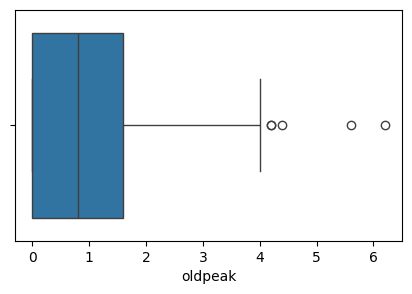

In [ ]:
#Analyse des outliers (valeurs aberrantes)
for var in Num_Cols : 
    plt.figure(figsize = (5 , 3))
    sns.boxplot(data = data , x = var)
    plt.show()

#### **Variables qualitatives**

In [73]:
data[Cat_Cols].describe().T

,count,unique,top,freq
sex,297,2,Homme,201
cp,297,4,Asymptomatique,142
fbs,297,2,Non,254
restecg,297,3,Normal,147
exang,297,2,Non,200
slope,297,3,En hausse,139
ca,297,4,Absence d'anomalie,174
thal,297,3,Normal,164
condition,297,2,Non,160


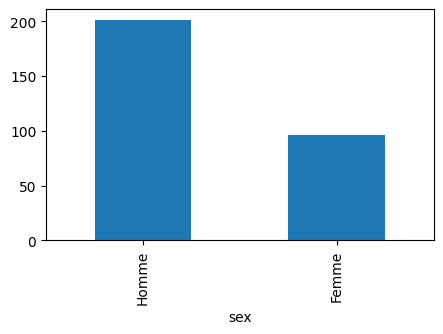

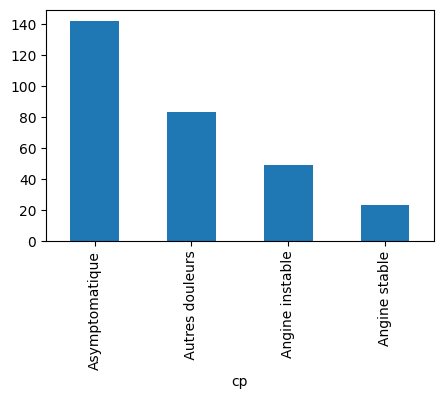

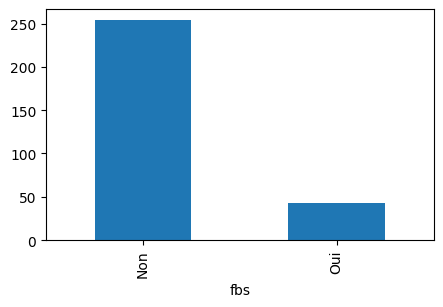

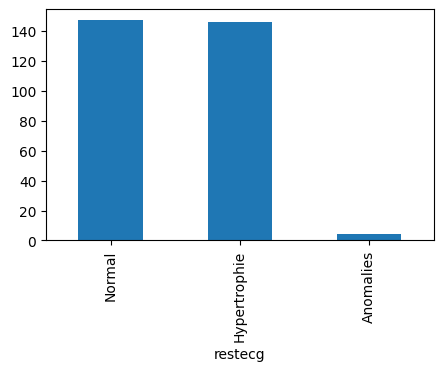

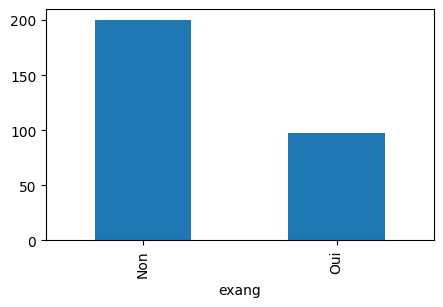

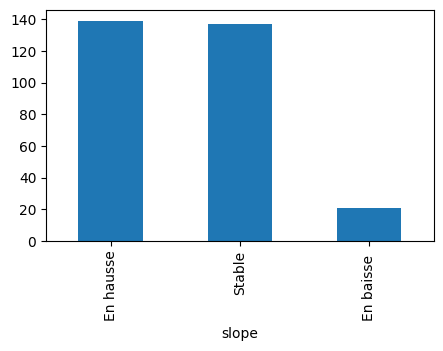

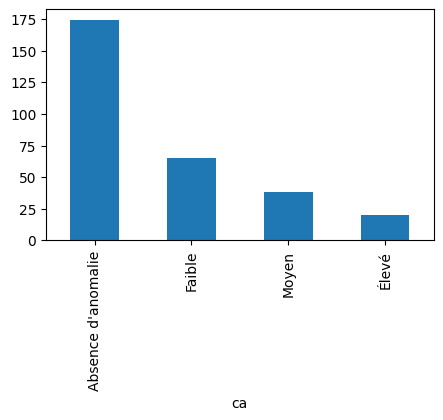

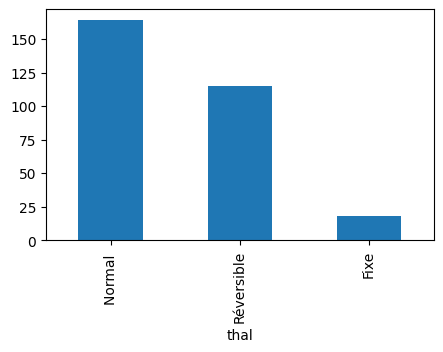

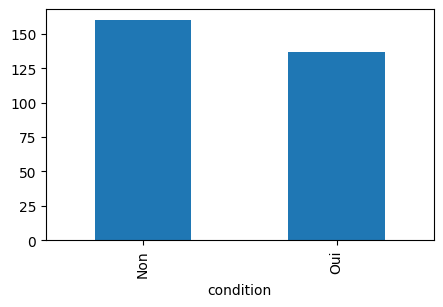

In [19]:
#Diagramme en barre
# sns.countplot(train[var]).set_tittle("")
for var in Cat_Cols :
    plt.figure(figsize = (5 , 3))
    data[var].value_counts().plot.bar()
    plt.show()

### **Analyse Multivariée**

#### **Variables quantitatives**

C:\Users\user\AppData\Local\Temp\ipykernel_12760\2821479007.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = data , y = var , x = "condition", palette='viridis')


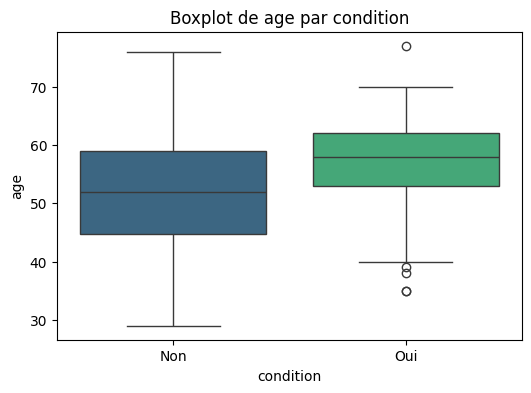

C:\Users\user\AppData\Local\Temp\ipykernel_12760\2821479007.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = data , y = var , x = "condition", palette='viridis')


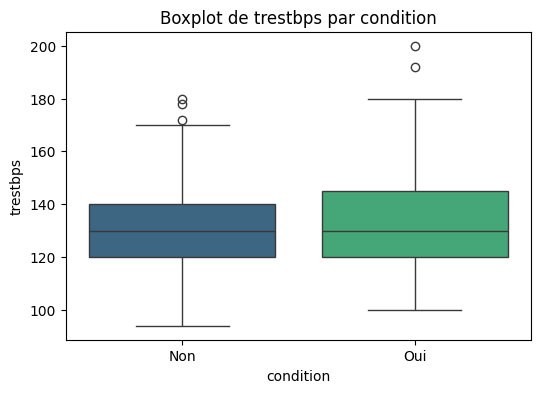

C:\Users\user\AppData\Local\Temp\ipykernel_12760\2821479007.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = data , y = var , x = "condition", palette='viridis')


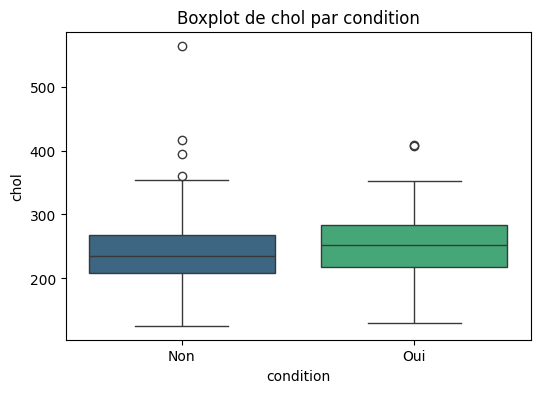

C:\Users\user\AppData\Local\Temp\ipykernel_12760\2821479007.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = data , y = var , x = "condition", palette='viridis')


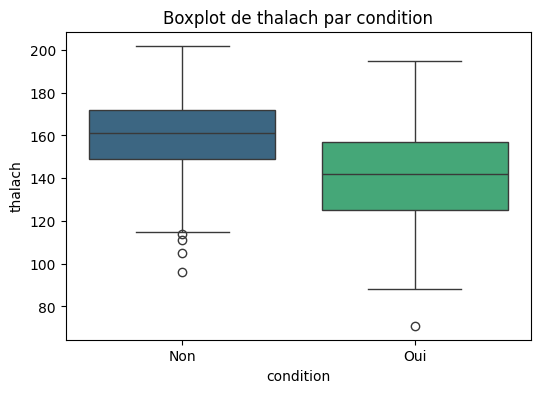

C:\Users\user\AppData\Local\Temp\ipykernel_12760\2821479007.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data = data , y = var , x = "condition", palette='viridis')


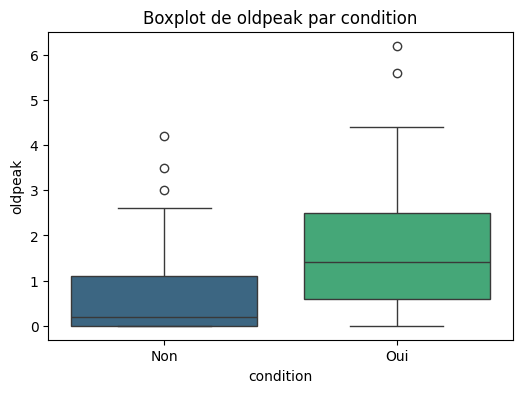

In [20]:
#ANOVA de manière graphique 
for var in Num_Cols : 
    plt.figure(figsize = (6 , 4))
    sns.boxplot(data = data , y = var , x = "condition", palette='viridis')
    plt.title(f"Boxplot de {var} par condition")
    plt.show()

#### **Variables qualitatives**

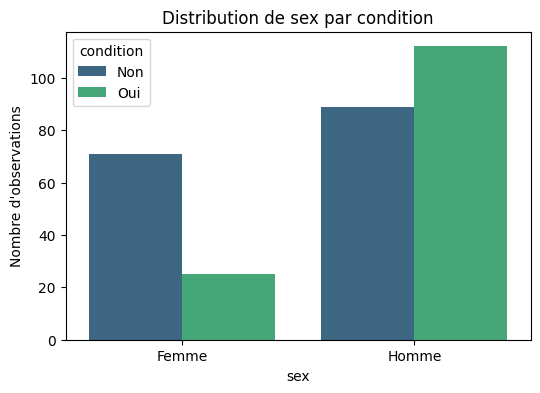

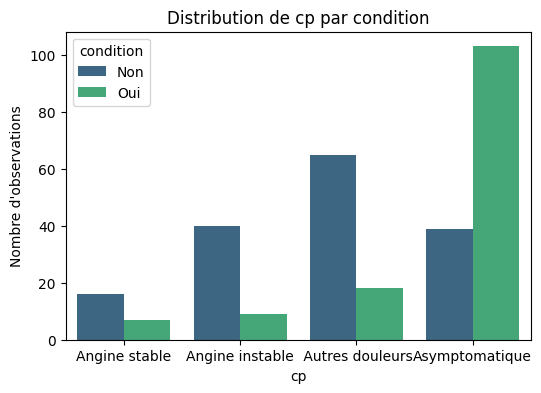

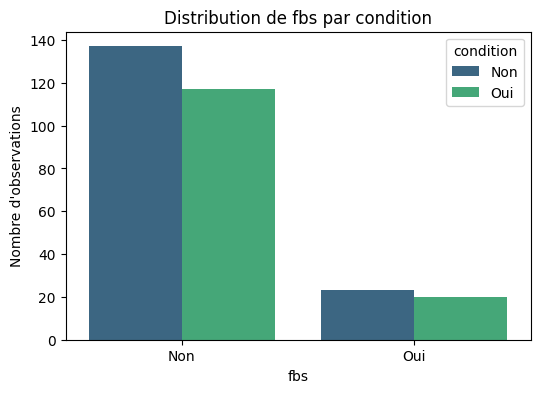

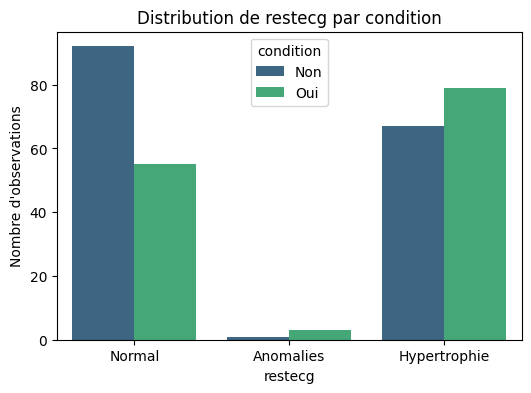

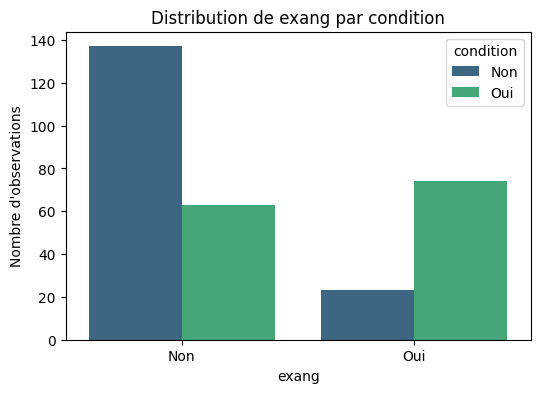

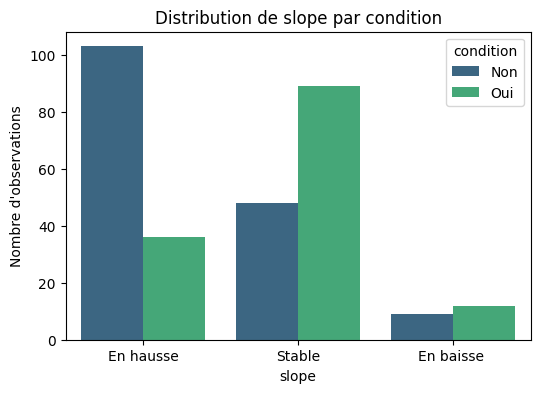

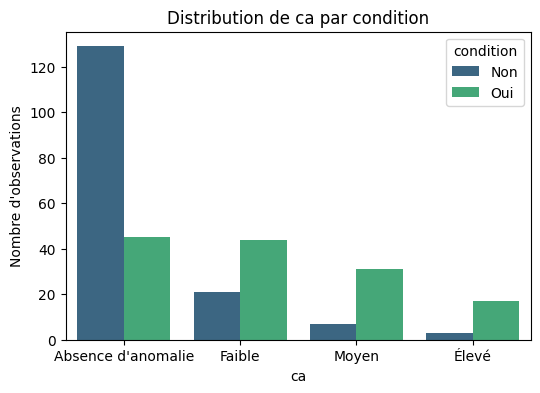

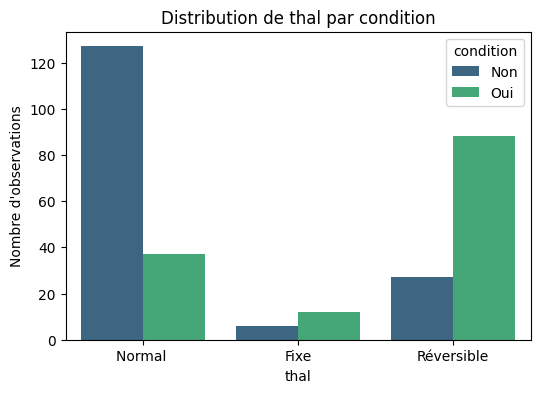

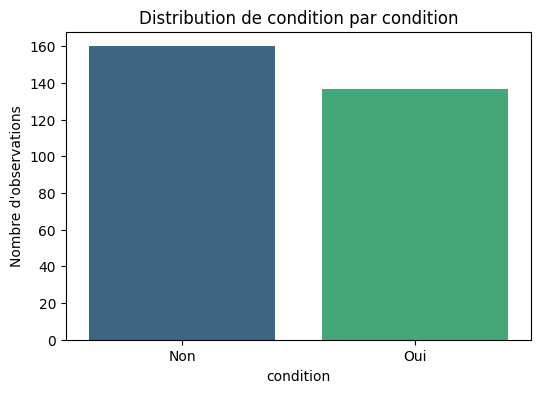

In [21]:
for var in Cat_Cols:
    plt.figure(figsize=(6, 4))
    sns.countplot(data=data, x=var, hue="condition", palette='viridis')
    plt.title(f"Distribution de {var} par condition")
    plt.ylabel("Nombre d'observations")
    plt.show()

### **Visualisation de la variable cible (condition )**

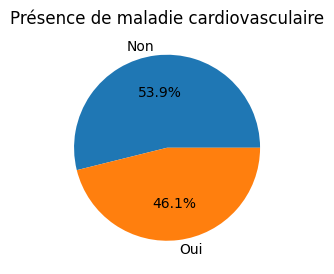

In [22]:
plt.figure(figsize=(3, 10))
data['condition'].value_counts().plot.pie(autopct='%1.1f%%')
plt.title('Présence de maladie cardiovasculaire')
plt.ylabel("")
plt.show()

La variable **condition** est une variable binaire avec deux modalités (**0 = Non**, **1 = Oui**).

Le pourcentage de la classe **Non** est de **53.9** et celui de la classe **Oui** est de **46.1** , 

il n'y a pas de grande différence entre ces deux classes ( les classes ne  se sont pas trop déséquilibrées).

Donc pas nécessaire de l'équilibré.


## **Pretraitement**

In [23]:
# copie de la base 
df = base.copy()
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0


### **Imputation des valeurs aberrantes**

In [24]:
# définition d'une fonction d'imputation des outliers
def imputeOutliers(df , x ):
    Q1 = df[x].quantile(0.25) #quartile d'ordre 1
    Q3 = df[x].quantile(0.75) #quartile d'ordre 3
    IQR = Q3 - Q1 #écart interquartile
    min = Q1 - 1.5*IQR
    max = Q3 + 1.5*IQR
    df.loc[df[x] < min , x ] = min 
    df.loc[df[x] > max , x ] = max 
    return df

In [25]:
#copy de la base de données
dfNoOutliers = df.copy()
#imputation des outliers
for var in Num_Cols :
   dfNoOutliers = imputeOutliers(dfNoOutliers , var)

C:\Users\user\AppData\Local\Temp\ipykernel_12760\2330439210.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '28.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[x] < min , x ] = min
C:\Users\user\AppData\Local\Temp\ipykernel_12760\2330439210.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '113.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[x] < min , x ] = min
C:\Users\user\AppData\Local\Temp\ipykernel_12760\2330439210.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '83.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[x] < min , x ] = min


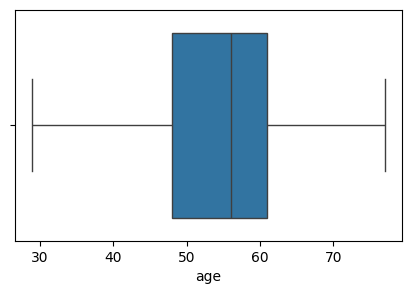

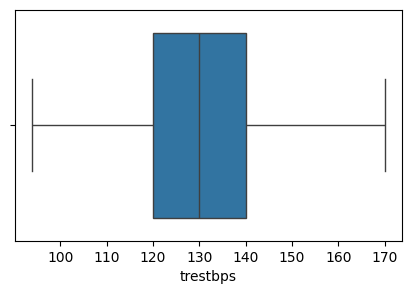

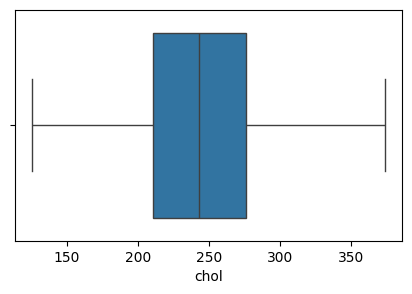

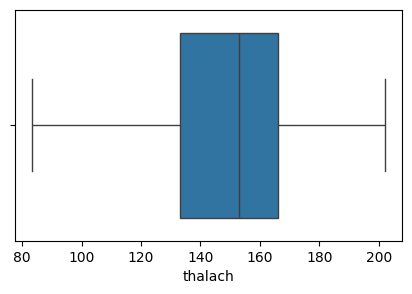

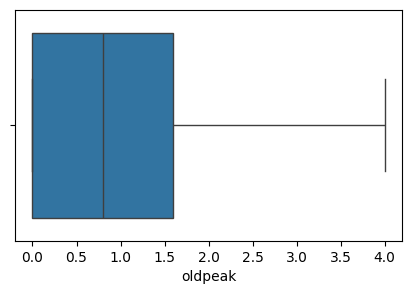

In [26]:
# vérification des outliers 
for var in Num_Cols : 
    plt.figure(figsize = (5 , 3))
    sns.boxplot(data = dfNoOutliers , x = var)
    plt.show()

## **Division des donnees en X/Y**

In [27]:
X = dfNoOutliers.drop("condition",axis=1)
X = sm. add_constant (X) # Ajout d'une constante (intercept)
Y = dfNoOutliers ["condition"]

In [28]:
X.head()

,const,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,1.0,69.0,1,0,160,234.0,1,2,131.0,0,0.1,1,1,0
1,1.0,69.0,0,0,140,239.0,0,0,151.0,0,1.8,0,2,0
2,1.0,66.0,0,0,150,226.0,0,0,114.0,0,2.6,2,0,0
3,1.0,65.0,1,0,138,282.0,1,2,174.0,0,1.4,1,1,0
4,1.0,64.0,1,0,110,211.0,0,2,144.0,1,1.8,1,0,0


In [29]:
Y.head()

0    0
1    0
2    0
3    1
4    0
Name: condition, dtype: int64

## **Normalisation**

In [30]:
from sklearn.preprocessing import StandardScaler
# StandardScaler qui soustrait par la moyenne et le divise par l'écartye 
#instanciation 
scaler = StandardScaler()

In [31]:
X.loc[: , Num_Cols] = scaler.fit_transform(X[Num_Cols])

C:\Users\user\AppData\Local\Temp\ipykernel_12760\432400796.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.70848443  0.5160984   1.11229141  0.3968598  -1.27248065  2.30467745
  0.81419491  0.15838259  1.11229141  2.30467745  2.30467745  1.70848443
  0.15838259  1.11229141 -0.67628763 -0.79552624  1.23153002 -0.37819113
 -1.27248065  0.99305281  0.5160984  -0.67628763 -0.79552624 -0.67628763
  1.70848443  1.47000722  1.70848443  0.5160984  -0.67628763 -0.19933322
  0.5160984  -0.67628763  0.27762119 -0.08009462 -0.43781043  1.35076862
 -0.67628763  0.5160984  -0.67628763 -0.08009462  0.21800189 -0.08009462
  0.03914399 -1.39171925  0.03914399  2.30467745 -0.67628763  0.15838259
 -0.19933322 -0.67628763  0.15838259 -0.08009462 -1.27248065 -0.08009462
 -1.80905436 -1.57057716 -0.08009462 -1.15324205 -0.19933322 -0.67628763
 -0.08009462 -0.67628763 -0.67628763  0.21800189 -0.08009462 -1.57057716
 -1.27248065 -

In [32]:
X.head()

,const,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,1.0,1.600302,1,0,1.708484,-0.256741,1,2,-0.818700,0,-0.844856,1,1,0
1,1.0,1.600302,0,0,0.516098,-0.152042,0,0,0.059667,0,0.682965,0,2,0
2,1.0,1.268242,0,0,1.112291,-0.424258,0,0,-1.565312,0,1.401940,2,0,0
3,1.0,1.157555,1,0,0.396860,0.748366,1,2,1.069789,0,0.323478,1,1,0
4,1.0,1.046868,1,0,-1.272481,-0.738354,0,2,-0.247762,1,0.682965,1,0,0


## 2. **Modélisation principale**

### **Modèle de régression logistique**

#### **model avec toutes les variables**

In [33]:
model = sm.Logit(Y, X)

### **Ajustement avec Fisher - Scoring**

In [34]:
resultat = model.fit( method ="newton")

Optimization terminated successfully.
         Current function value: 0.341521
         Iterations 7


In [35]:
# Resumé des resultats
print(resultat.summary())

                           Logit Regression Results                           
Dep. Variable:              condition   No. Observations:                  297
Model:                          Logit   Df Residuals:                      283
Method:                           MLE   Df Model:                           13
Date:                Wed, 21 May 2025   Pseudo R-squ.:                  0.5051
Time:                        08:07:57   Log-Likelihood:                -101.43
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 4.785e-37
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4710      0.706     -6.328      0.000      -5.856      -3.086
age           -0.1175      0.217     -0.542      0.588      -0.543       0.308
sex            1.3773      0.487      2.827      0.0

In [36]:
# Afficher AIC et BIC
print("AIC:", resultat.aic.round(2))
print("BIC:", resultat.bic.round(2))
print("Log-vraisemblance:",resultat.llf.round(2))

AIC: 230.86
BIC: 282.58
Log-vraisemblance: -101.43


#### **model avec  les variables réduites ( age supprimée)**

In [37]:
X_1=X.drop("age",axis=1)
X_1.head()

,const,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,1.0,1,0,1.708484,-0.256741,1,2,-0.818700,0,-0.844856,1,1,0
1,1.0,0,0,0.516098,-0.152042,0,0,0.059667,0,0.682965,0,2,0
2,1.0,0,0,1.112291,-0.424258,0,0,-1.565312,0,1.401940,2,0,0
3,1.0,1,0,0.396860,0.748366,1,2,1.069789,0,0.323478,1,1,0
4,1.0,1,0,-1.272481,-0.738354,0,2,-0.247762,1,0.682965,1,0,0


In [38]:
model1 = sm.Logit(Y, X_1)

resultat1 = model1.fit( method ="newton")

Optimization terminated successfully.
         Current function value: 0.342016
         Iterations 7


In [39]:
# Resumé des resultats
print(resultat1.summary())

                           Logit Regression Results                           
Dep. Variable:              condition   No. Observations:                  297
Model:                          Logit   Df Residuals:                      284
Method:                           MLE   Df Model:                           12
Date:                Wed, 21 May 2025   Pseudo R-squ.:                  0.5044
Time:                        08:07:57   Log-Likelihood:                -101.58
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 1.291e-37
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.4879      0.705     -6.368      0.000      -5.869      -3.107
sex            1.4130      0.482      2.934      0.003       0.469       2.357
cp             0.5874      0.191      3.076      0.0

In [40]:
# Afficher AIC et BIC
print("AIC:", resultat1.aic.round(2))
print("BIC:", resultat1.bic.round(2))
print("Log-vraisemblance:",resultat1.llf.round(2))

AIC: 229.16
BIC: 277.18
Log-vraisemblance: -101.58


#### **Test du rapport de vraisemblance entre model et model1**

In [41]:
from scipy.stats import chi2

# Calcul de la statistique du test
LR_stat = -2 * (resultat1.llf - resultat.llf)  # -2 * (log-vraisemblance réduit - log-vraisemblance complet)

# Degrés de liberté (différence du nombre de paramètres)
df = resultat.df_model - resultat1.df_model  

# Calcul de la p-value
p_value = chi2.sf(LR_stat, df)

# Affichage des résultats
print(f"Statistique du test : {LR_stat:.4f}")
print(f"Degrés de liberté   : {df}")
print(f"p-value             : {p_value:.4f}")

if p_value < 0.05:
    print("Conclusion :Le modèle (m) est significativement meilleur que le modèle (m1) au seuil de 5%.")
else:
    print("Conclusion :Le modèle (m) n'est pas significativement meilleur que le modèle (m1)")

Statistique du test : 0.2942
Degrés de liberté   : 1.0
p-value             : 0.5875
Conclusion :Le modèle (m) n'est pas significativement meilleur que le modèle (m1)


#### **model avec  les variables réduites ( restecg supprimée)**

In [42]:
X_2=X_1.drop("restecg",axis=1)
X_2.head()

,const,sex,cp,trestbps,chol,fbs,thalach,exang,oldpeak,slope,ca,thal
0,1.0,1,0,1.708484,-0.256741,1,-0.818700,0,-0.844856,1,1,0
1,1.0,0,0,0.516098,-0.152042,0,0.059667,0,0.682965,0,2,0
2,1.0,0,0,1.112291,-0.424258,0,-1.565312,0,1.401940,2,0,0
3,1.0,1,0,0.396860,0.748366,1,1.069789,0,0.323478,1,1,0
4,1.0,1,0,-1.272481,-0.738354,0,-0.247762,1,0.682965,1,0,0


In [43]:
model2 = sm.Logit(Y, X_2)

resultat2 = model2.fit( method ="newton")

Optimization terminated successfully.
         Current function value: 0.344764
         Iterations 7


In [44]:
# Resumé des resultats
print(resultat2.summary())

                           Logit Regression Results                           
Dep. Variable:              condition   No. Observations:                  297
Model:                          Logit   Df Residuals:                      285
Method:                           MLE   Df Model:                           11
Date:                Wed, 21 May 2025   Pseudo R-squ.:                  0.5004
Time:                        08:07:58   Log-Likelihood:                -102.40
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 6.325e-38
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.3085      0.683     -6.309      0.000      -5.647      -2.970
sex            1.4801      0.479      3.091      0.002       0.541       2.419
cp             0.5816      0.190      3.054      0.0

In [45]:
# Afficher AIC et BIC
print("AIC:", resultat2.aic.round(2))
print("BIC:", resultat2.bic.round(2))
print("Log-vraisemblance:",resultat2.llf.round(2))

AIC: 228.79
BIC: 273.11
Log-vraisemblance: -102.4


#### **Test du rapport de vraisemblance entre model1 et model2**

In [46]:
from scipy.stats import chi2

# Calcul de la statistique du test
LR_stat1 = -2 * (resultat2.llf - resultat1.llf)  # -2 * (log-vraisemblance réduit - log-vraisemblance complet)

# Degrés de liberté (différence du nombre de paramètres)
df1 = resultat1.df_model - resultat2.df_model  

# Calcul de la p-value
p_value1 = chi2.sf(LR_stat1, df1)

# Affichage des résultats
print(f"Statistique du test : {LR_stat1:.4f}")
print(f"Degrés de liberté   : {df1}")
print(f"p-value             : {p_value1:.4f}")

if p_value1 < 0.05:
    print("Conclusion : Le modèle (m1) est significativement meilleur que le modèle (m2) au seuil de 5%.")
else:
    print("Conclusion : Le modèle (m1) n'est pas significativement meilleur que le modèle (m2).")

Statistique du test : 1.6324
Degrés de liberté   : 1.0
p-value             : 0.2014
Conclusion : Le modèle (m1) n'est pas significativement meilleur que le modèle (m2).


#### **model avec  les variables réduites ( oldpeak supprimée)**

In [47]:
X_3=X_2.drop("oldpeak",axis=1)
X_3.head()

,const,sex,cp,trestbps,chol,fbs,thalach,exang,slope,ca,thal
0,1.0,1,0,1.708484,-0.256741,1,-0.818700,0,1,1,0
1,1.0,0,0,0.516098,-0.152042,0,0.059667,0,0,2,0
2,1.0,0,0,1.112291,-0.424258,0,-1.565312,0,2,0,0
3,1.0,1,0,0.396860,0.748366,1,1.069789,0,1,1,0
4,1.0,1,0,-1.272481,-0.738354,0,-0.247762,1,1,0,0


In [48]:
model3 = sm.Logit(Y, X_3)

resultat3 = model3.fit( method ="newton")

Optimization terminated successfully.
         Current function value: 0.347368
         Iterations 7


In [49]:
# Resumé des resultats
print(resultat3.summary())

                           Logit Regression Results                           
Dep. Variable:              condition   No. Observations:                  297
Model:                          Logit   Df Residuals:                      286
Method:                           MLE   Df Model:                           10
Date:                Wed, 21 May 2025   Pseudo R-squ.:                  0.4967
Time:                        08:07:59   Log-Likelihood:                -103.17
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 2.850e-38
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.5427      0.665     -6.827      0.000      -5.847      -3.239
sex            1.5522      0.475      3.269      0.001       0.621       2.483
cp             0.5741      0.191      3.011      0.0

In [50]:
# Afficher AIC et BIC
print("AIC:", resultat3.aic.round(2))
print("BIC:", resultat3.bic.round(2))
print("Log-vraisemblance:",resultat3.llf.round(2))

AIC: 228.34
BIC: 268.97
Log-vraisemblance: -103.17


#### **Test du rapport de vraisemblance entre model2 et model3**

In [51]:
from scipy.stats import chi2

# Calcul de la statistique du test
LR_stat2 = -2 * (resultat3.llf - resultat2.llf)  # -2 * (log-vraisemblance réduit - log-vraisemblance complet)

# Degrés de liberté (différence du nombre de paramètres)
df2 = resultat2.df_model - resultat3.df_model  

# Calcul de la p-value
p_value2 = chi2.sf(LR_stat2, df2)

# Affichage des résultats
print(f"Statistique du test : {LR_stat2:.4f}")
print(f"Degrés de liberté   : {df2}")
print(f"p-value             : {p_value2:.4f}")

if p_value2 < 0.05:
    print("Conclusion : Le modèle (m2) est significativement meilleur que le modèle (m3) au seuil de 5%.")
else:
    print("Conclusion : Le modèle (m2) n'est pas significativement meilleur que le modèle (m3).")

Statistique du test : 1.5467
Degrés de liberté   : 1.0
p-value             : 0.2136
Conclusion : Le modèle (m2) n'est pas significativement meilleur que le modèle (m3).


#### **model avec  les variables réduites ( fbs supprimée)**

In [52]:
X_4=X_3.drop("fbs",axis=1)
X_4.head()

,const,sex,cp,trestbps,chol,thalach,exang,slope,ca,thal
0,1.0,1,0,1.708484,-0.256741,-0.818700,0,1,1,0
1,1.0,0,0,0.516098,-0.152042,0.059667,0,0,2,0
2,1.0,0,0,1.112291,-0.424258,-1.565312,0,2,0,0
3,1.0,1,0,0.396860,0.748366,1.069789,0,1,1,0
4,1.0,1,0,-1.272481,-0.738354,-0.247762,1,1,0,0


In [53]:
model4 = sm.Logit(Y, X_4)

resultat4 = model4.fit( method ="newton")

Optimization terminated successfully.
         Current function value: 0.353999
         Iterations 7


In [54]:
# Resumé des resultats
print(resultat4.summary())

                           Logit Regression Results                           
Dep. Variable:              condition   No. Observations:                  297
Model:                          Logit   Df Residuals:                      287
Method:                           MLE   Df Model:                            9
Date:                Wed, 21 May 2025   Pseudo R-squ.:                  0.4871
Time:                        08:08:00   Log-Likelihood:                -105.14
converged:                       True   LL-Null:                       -204.97
Covariance Type:            nonrobust   LLR p-value:                 3.883e-38
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -4.5364      0.654     -6.931      0.000      -5.819      -3.254
sex            1.4522      0.467      3.107      0.002       0.536       2.368
cp             0.5967      0.190      3.138      0.0

In [55]:
# Afficher AIC et BIC
print("AIC:", resultat4.aic.round(2))
print("BIC:", resultat4.bic.round(2))
print("Log-vraisemblance:",resultat4.llf.round(2))

AIC: 230.28
BIC: 267.21
Log-vraisemblance: -105.14


#### **Test du rapport de vraisemblance entre model3 et model4**

In [56]:
from scipy.stats import chi2

# Calcul de la statistique du test
LR_stat3 = -2 * (resultat4.llf - resultat3.llf)  # -2 * (log-vraisemblance réduit - log-vraisemblance complet)

# Degrés de liberté (différence du nombre de paramètres)
df3 = resultat3.df_model - resultat4.df_model  

# Calcul de la p-value
p_value3 = chi2.sf(LR_stat3, df3)

# Affichage des résultats
print(f"Statistique du test : {LR_stat3:.4f}")
print(f"Degrés de liberté   : {df3}")
print(f"p-value             : {p_value3:.4f}")

if p_value3 < 0.05:
    print("Conclusion : Le modèle (m3) est significativement meilleur que le modèle (m4) au seuil de 5%.")
else:
    print("Conclusion : Le modèle (m3) n'est pas significativement meilleur que le modèle (m4).")

Statistique du test : 3.9388
Degrés de liberté   : 1.0
p-value             : 0.0472
Conclusion : Le modèle (m3) est significativement meilleur que le modèle (m4) au seuil de 5%.


**Conclusion:** Le **modèle m3** est le meilleur modèle

## **3. Validation et diagnostics du modèle**

### **a. Analyse des résidus : Résidus de Pearson, Déviants et Studentisés**

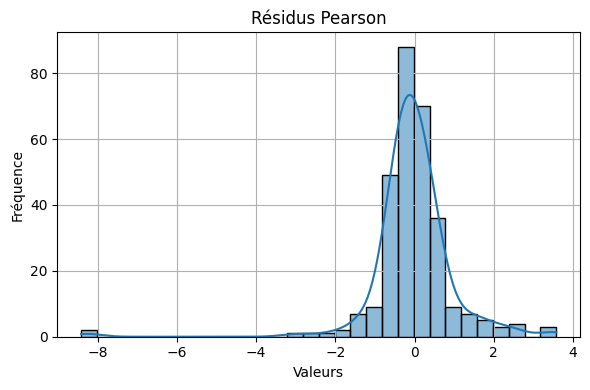

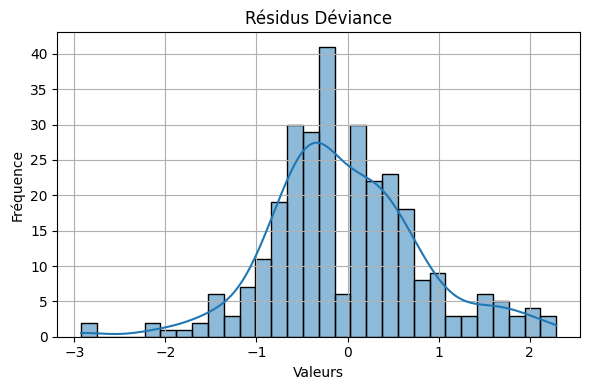

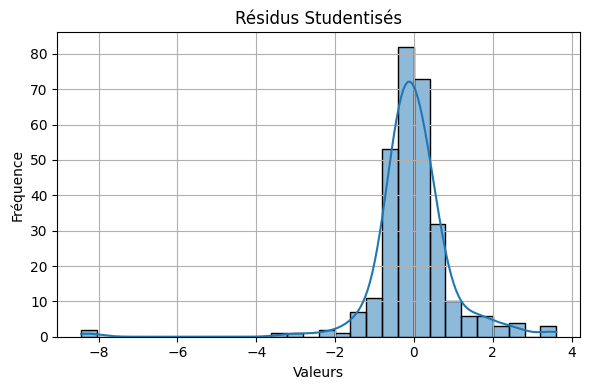

In [57]:
# Résidus à partir du modèle Logit ajusté
residuals = {
    "Pearson": resultat3.resid_pearson,
    "Déviance": resultat3.resid_dev,
    "Studentisés": resultat3.resid_pearson / np.sqrt(1 - resultat3.get_influence().hat_matrix_diag)
}

# Affichage de chaque histogramme dans une figure séparée
for name, resid in residuals.items():
    plt.figure(figsize=(6, 4))
    sns.histplot(resid, kde=True, bins=30)
    plt.title(f"Résidus {name}")
    plt.xlabel("Valeurs")
    plt.ylabel("Fréquence")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


### **b. Détection des points atypiques : Distance de Cook et Résidus Studentisés**

In [58]:
# Distance de Cook
influence = resultat3.get_influence()
cooks_distance = influence.cooks_distance[0]

# Seuil pour les points influents (4/n est une règle empirique)
n = len(resultat3.model.endog)
threshold_cook = 4 / n

# Points influents
outliers_cook = np.where(cooks_distance > threshold_cook)[0]

# Résidus studentisés
resid_student = residuals["Studentisés"]
outliers_student = np.where(np.abs(resid_student) > 2)[0]

print(f"Points influents (Cook > {threshold_cook:.3f}): {outliers_cook}")
print(f"Valeurs aberrantes (|Résidus studentisés| > 2): {outliers_student}")

Points influents (Cook > 0.013): [  3   9  11  12  18  21  31  32  33  52  87  90 107 115 123 133 176 177
 182 195 205 254 256 281 290]
Valeurs aberrantes (|Résidus studentisés| > 2): [  3   9  11  31  32  33  90  93 133 176 177 195 205 254 256 281]


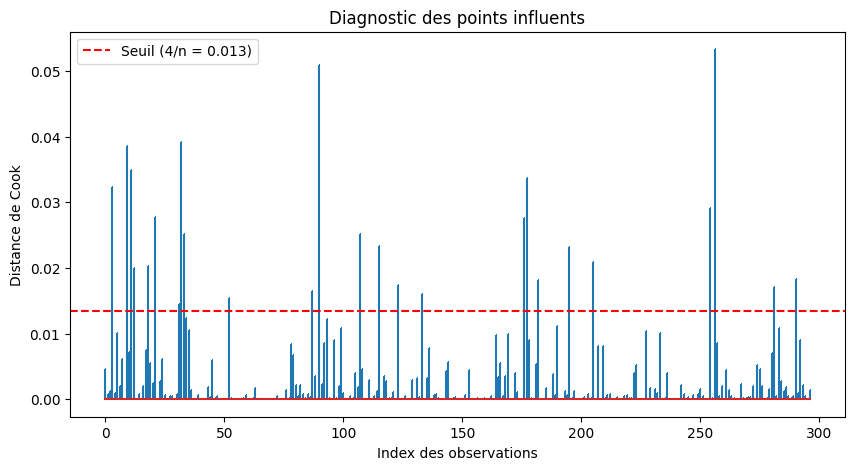

In [59]:
plt.figure(figsize=(10, 5))
plt.stem(cooks_distance, markerfmt=",")
plt.axhline(y=threshold_cook, color='r', linestyle='--', label=f"Seuil (4/n = {threshold_cook:.3f})")
plt.xlabel("Index des observations")
plt.ylabel("Distance de Cook")
plt.title("Diagnostic des points influents")
plt.legend()
plt.show()

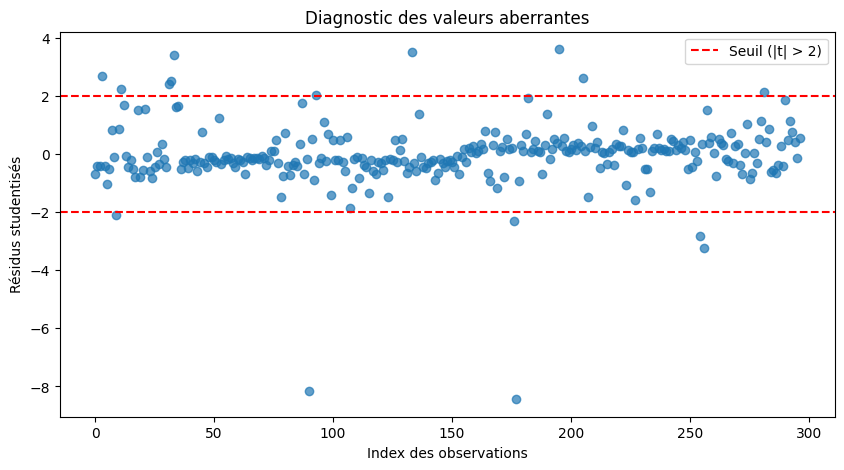

In [60]:
plt.figure(figsize=(10, 5))
plt.scatter(range(n), resid_student, alpha=0.7)
plt.axhline(y=2, color='r', linestyle='--', label="Seuil (|t| > 2)")
plt.axhline(y=-2, color='r', linestyle="--")
plt.xlabel("Index des observations")
plt.ylabel("Résidus studentisés")
plt.title("Diagnostic des valeurs aberrantes")
plt.legend()
plt.show()

### **c. Multicolinéarité : calcul des VIF**

In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Calcul des VIF pour chaque variable (hors intercept)
X = resultat3.model.exog[:, 1:]  # Exclut la colonne 'const'
vif = pd.DataFrame()
vif["Variable"] = resultat3.model.exog_names[1:]
vif["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print("\nFacteurs d'Inflation de Variance (VIF):")
print(vif.sort_values("VIF", ascending=False))


Facteurs d'Inflation de Variance (VIF):
   Variable       VIF
1        cp  3.754937
0       sex  3.050857
9      thal  2.505850
7     slope  2.181436
6     exang  2.019774
8        ca  1.807998
5   thalach  1.272148
4       fbs  1.220645
2  trestbps  1.093351
3      chol  1.087376


## **4. Évaluation de la performance du modèle**

### **a. Courbe ROC et AUC**

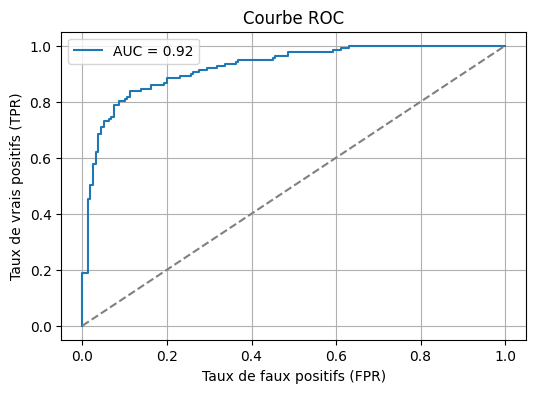

In [62]:
from sklearn.metrics import precision_score ,recall_score
# Prédictions de probabilité (avec le modèle statsmodels ajusté)
y_prob = resultat3.predict(X_3)  # ou X_test si vous faites une validation

# 1. Courbe ROC et AUC
fpr, tpr, thresholds = roc_curve(Y, y_prob)
auc_score = roc_auc_score(Y, y_prob)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC")
plt.legend()
plt.grid(True)
plt.show()

### **b. Matrice de confusion, précision, rappel, F1-score**

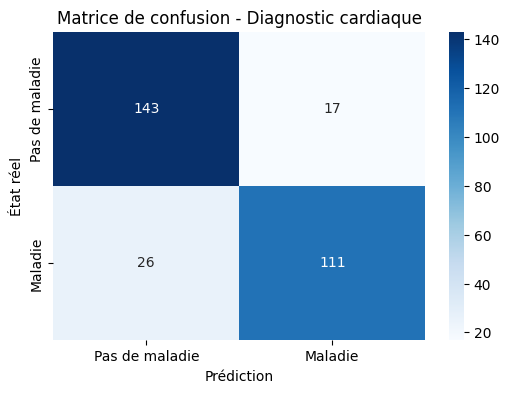

In [63]:
# 2. Seuil de classification
threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# Calcul de la matrice de confusion
cm = confusion_matrix(Y, y_pred)

# Heatmap brute
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pas de maladie', 'Maladie'],
            yticklabels=['Pas de maladie', 'Maladie'])
plt.xlabel('Prédiction')
plt.ylabel('État réel')
plt.title('Matrice de confusion - Diagnostic cardiaque')
plt.show()


In [64]:
print(f"Précision : {precision_score(Y, y_pred):.2f}") 
print(f"Rappel    : {recall_score(Y, y_pred):.2f}")
print(f"F1-score  : {f1_score(Y, y_pred):.2f}")

Précision : 0.87
Rappel    : 0.81
F1-score  : 0.84


### **c. Analyse du choix du seuil**

In [68]:
from sklearn.metrics import f1_score, precision_recall_curve

# Générer les scores de précision, rappel, seuils
precision, recall, thresholds = precision_recall_curve(Y, y_prob)

# Calculer le F1-score pour chaque seuil
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Seuil optimal (max F1-score) : {best_threshold:.2f}")


Seuil optimal (max F1-score) : 0.46


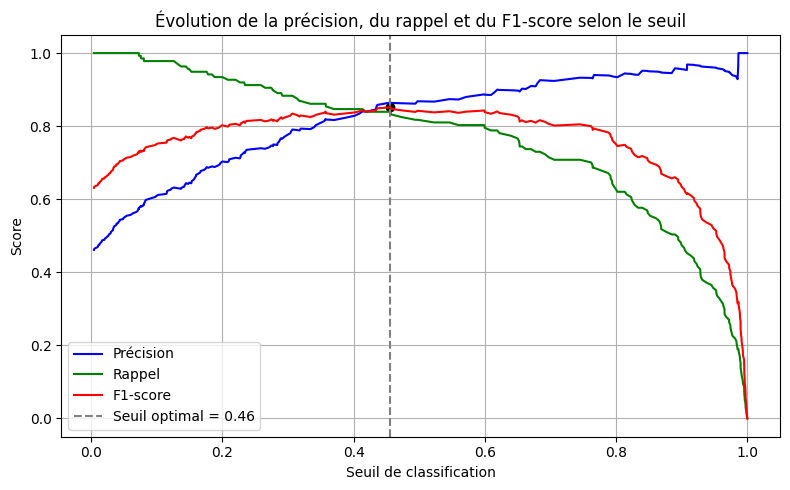

 Seuil optimal (max F1-score) : 0.46


In [69]:

# Précision, rappel et seuils
precision, recall, thresholds = precision_recall_curve(Y, y_prob)

# Calcul du F1-score pour chaque seuil
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)  # éviter division par zéro

# Ajouter un seuil à la fin pour cohérence des courbes
thresholds = np.append(thresholds, 1.0)

# Tracer les courbes
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision, label='Précision', color='blue')
plt.plot(thresholds, recall, label='Rappel', color='green')
plt.plot(thresholds, f1_scores, label='F1-score', color='red')

# Marquer le seuil optimal (max F1)
best_thresh = thresholds[np.argmax(f1_scores)]
best_f1 = np.max(f1_scores)
plt.axvline(best_thresh, linestyle='--', color='grey', label=f'Seuil optimal = {best_thresh:.2f}')
plt.scatter(best_thresh, best_f1, color='black')

# Mise en forme
plt.xlabel("Seuil de classification")
plt.ylabel("Score")
plt.title("Évolution de la précision, du rappel et du F1-score selon le seuil")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Affichage du meilleur seuil
print(f" Seuil optimal (max F1-score) : {best_thresh:.2f}")


In [70]:
threshold = 0.46
y_pred = (y_prob >= threshold).astype(int)
print(f"Précision : {precision_score(Y, y_pred):.2f}") 
print(f"Rappel    : {recall_score(Y, y_pred):.2f}")
print(f"F1-score  : {f1_score(Y, y_pred):.2f}")

Précision : 0.86
Rappel    : 0.82
F1-score  : 0.84


## **6. Extension possible**

In [71]:
# Résidus de Pearson
resid_pearson = resultat3.resid_pearson

# Calcul de la statistique de dispersion
dispersion = np.sum(resid_pearson**2) / resultat3.df_resid

print(f"Statistique de dispersion : {dispersion:.2f}")

# Interprétation
if dispersion > 1.5:
    print("Surdispersion détectée : envisagez un modèle quasi-binomial ou une régularisation Lasso/Ridge")
elif dispersion < 0.5:
    print(" Sous-dispersion possible")
else:
    print("Pas de surdispersion : ajustement correct")


Statistique de dispersion : 1.17
Pas de surdispersion : ajustement correct
